In [1]:
from osier import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import dill
import types
from functools import partial
from mycolorpy import colorlist as mcp
import matplotlib.gridspec as gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable 

In [2]:
# path = "../data/2023-05-30-NOBJ4-USNGA3-results.pkl"
path = "../../osier_data/2023-05-30-NOBJ4-USNGA3-results.pkl"
with open(path, 'rb') as file:
    results = dill.load(file)

In [3]:
results.exec_time/3600/24

26.450016904694063

In [4]:
techs = get_tech_names(results.problem.technology_list)

In [5]:
F = results.F
slack = 0.1
F_slack = F*(1+slack)

In [6]:
def get_objective_names(res_obj):
    """
    This function returns a list of named objectives based on the
    names of the functions passed to Osier. In the case of partial
    functions, the first keyword value is used.
    
    Parameters
    ----------
    res_obj : :class:pymoo.Result
        The simulation results object containing all data and metadata.
    
    Returns
    -------
    obj_columns : list of str
        A list of function name strings.
    """
    obj_columns=[]
    for ofunc in res_obj.problem.objectives:
        if isinstance(ofunc, types.FunctionType):
            obj_columns.append(ofunc.__name__)
        elif isinstance(ofunc, functools.partial):
            obj_columns.append(list(ofunc.keywords.values())[0]) 
    return obj_columns

In [7]:
def moo_mga(res_obj, slack=0.1, sense='minimize'):
    """
    This function determines which individuals are 
    within the boundaries of a 'sub-optimal front'
    determined by a provided slack value.
    
    Parameters
    ----------
    res_obj : :class:pymoo.Result
        The simulation results object containing all data and metadata.
    slack : float
        The slack value for the sub-optimal front. 
    sense : str
        Indicates whether the optimization was a minimization 
        or maximization. If min, the sub-optimal front is greater
        than the Pareto front. If max, the sub-optimal front is 
        below the Pareto front.
        
        
    .. warning::
        This method will produce duplicates in most cases since it
        checks the population history and the population history
        does not have unique values due to the nature of genetic
        algorithms (i.e. good solutions persist in the gene pool).
    """
    pf = res_obj.F
    if sense.lower() == 'minimize':
        pf_slack = pf*(1+slack)
    elif sense.lower() == 'maximize':
        pf_slack = pf*(1-slack)
        
    n_objs = res_obj.problem.n_obj
    
    interior_dict = {n:[] for n in range(n_objs+1)}
    cols = get_objective_names(res_obj) + ['designs']
    
    # get list of all points
    for h in res_obj.history:
        # the history of each population, individual, 
        # and their corresponding design spaces.
        F_hist = h.pop.get("F")  # objective space
        X_hist = h.pop.get("X")  # design space
    
        for p, x in zip(F_hist, X_hist):
            # check that all coordinates of a point are within the boundaries.
            cond1 = np.any((p < pf_slack).sum(axis=1)==n_objs)
            cond2 = np.any((p > pf).sum(axis=1)==n_objs)
            if cond1 and cond2:
                for i,c in enumerate(p):
                    interior_dict[i].append(c)
                interior_dict[n_objs].append(x)
    mga_df = pd.DataFrame(interior_dict)
    mga_df.columns = cols
    
    return mga_df

In [24]:
mdf = moo_mga(results)

In [25]:
mdf_nondup = mdf.iloc[:,:4].drop_duplicates()
mdf_nondup['designs'] = mdf.loc[list(mdf_nondup.index), 'designs'].values
mdf_nondup['optimal'] = 'Sub-opt'

In [26]:
obj_cols = get_objective_names(results)
obj_cols

['total_cost', 'lifecycle_co2_rate', 'land_use', 'percent_nonrenewable']

In [27]:
pf_obj = pd.DataFrame(dict(zip(obj_cols, F.T)))
pf_obj['designs'] = list(results.X)
pf_obj['optimal'] = 'Optimal'

In [28]:
combined = pd.concat([pf_obj, mdf_nondup], axis=0).reset_index(drop=True)
combined

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,designs,optimal
0,8291.759444,2.351402,6084.317408,0.988145,"[0.039226480521156376, 0.001350197892228162, 0...",Optimal
1,5916.763465,12.858772,2500.972545,0.961864,"[0.34243382498061536, 0.022397843653071375, 0....",Optimal
2,5815.156413,24.492174,66332.563041,0.868875,"[0.234814644933354, 0.00014630434248949845, 0....",Optimal
3,5430.836207,27.829462,29295.038375,0.935887,"[0.3542878851185257, 4.2289388436939936e-05, 0...",Optimal
4,13735.195512,40.555240,3418.998995,0.317540,"[9.336348950135593e-05, 0.7600850286245524, 0....",Optimal
5,6661.768444,14.515464,143.977120,0.999945,"[0.02243292966452215, 0.003791462480291834, 0....",Optimal
6,6014.911458,13.123974,15133.349082,0.936181,"[0.34243382498061536, 0.022397843653071375, 0....",Optimal
7,7647.064947,3.516937,872706.989399,0.001334,"[0.9029545721826879, 8.688571858164708e-08, 0....",Optimal
8,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0...",Sub-opt
9,6344.245186,21.654545,21507.462122,0.952233,"[0.7415620704463681, 0.006681875218057012, 0.0...",Sub-opt


In [29]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .1), xycoords=ax.transAxes)

# Parallel Coordinates Plot

In [52]:
from pymoo.visualization.pcp import PCP
import matplotlib as mpl


mpl.use("pgf")
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams['text.usetex'] = True
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['figure.edgecolor'] = 'k'
plt.rcParams['figure.facecolor'] = 'lightgray'
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = "serif"
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.shadow'] = True

In [31]:
obj_labels=['Total Cost', 'CO2eq', 'Land Use', 'Percent \nNonrenewable']

In [53]:
# plt.rcParams['figure.facecolor'] = 'lightgray'
# obj_labels = obj_cols.copy()
# obj_labels[1] = 'lifecycle_co2'

plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
           n_ticks=10,
           legend=(True, {'loc': "upper left"}),
           labels=obj_labels,
           figsize=(13,6),
           )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
# plot.add(results.F, color="grey", alpha=0.3)
plot.add(combined[combined.optimal=='Optimal'].iloc[:,:4].values, color="grey", alpha=0.3)



plot.add(results.F[0], linewidth=5, color="tab:green", label=r"Least CO$_2$")
plot.add(results.F[3], linewidth=5, color="tab:red", label="Least Cost")
plot.add(results.F[5], linewidth=5, color="tab:orange", label=r"Least Land Use")
plot.add(results.F[7], linewidth=5, color="tab:blue", label="Highest Renewable")
plot.show()
# plt.savefig("C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_objective_space.pgf")
plt.savefig("../docs/figures/4_obj_objective_space.pgf")

# MGA Solutions

In [54]:
# obj_labels = obj_cols.copy()
# obj_labels[1] = 'lifecycle_co2'
plot = PCP(title=("Objective Space (with MGA Solutions)", {'pad': 30, 'fontsize':20}),
           n_ticks=10,
           legend=(True, {'loc': "upper left"}),
           labels=obj_labels,
           figsize=(13,6),
           )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
plot.add(combined.iloc[:,:4].values, color="grey", alpha=0.3)



plot.add(results.F[0], linewidth=5, color="tab:green", label=r"Least CO$_2$")
plot.add(results.F[3], linewidth=5, color="tab:red", label="Least Cost")
plot.add(results.F[5], linewidth=5, color="tab:orange", label=r"Least Land Use")
plot.add(results.F[7], linewidth=5, color="tab:blue", label="Highest Renewable")
plot.show()
# plt.savefig("C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_objective_space_MGA.pgf")
plt.savefig("../docs/figures/4_obj_objective_space_MGA.pgf")

In [55]:
# obj_labels = obj_cols.copy()
# obj_labels[1] = 'lifecycle_co2'
objective = 'total_cost'
obj_name = {'lifecycle_co2_rate':'CO2eq',
              'total_cost':'Total Cost',
              'land_use':'Land Use',
              'percent_nonrenewable':'Percent Nonrenewable'}
plot = PCP(title=(f"Objective Space \n Highlighted: {obj_name[objective]}", {'pad': 30, 'fontsize':20}),
           n_ticks=10,
           legend=(False, {'loc': "upper left"}),
           labels=obj_labels,
           figsize=(12,6),
           )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
plot.add(combined.iloc[:,:4].values, color="grey", alpha=0.3)

obj_colors = {'lifecycle_co2_rate':'Greens_r',
              'total_cost':'Reds_r',
              'land_use':'Oranges_r',
              'percent_nonrenewable':'Blues_r'}
# objective = 'lifecycle_co2_rate'
n = 5
cmap = obj_colors[objective]
color=mcp.gen_color(cmap=cmap,n=n+1)

subset_df = combined.nsmallest(n=n,columns=[objective]).reset_index(drop=True)

for i in range(n):
    print(subset_df.loc[i, objective], color[i])
    plot.add(subset_df.iloc[i,:4].values, linewidth=3, color=color[i])
plot.show()
# plt.savefig(f"C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_objective_space_{objective}.pgf")
plt.savefig(f"../docs/figures/4_obj_objective_space_{objective}.pgf")

5430.836207103636 #67000d
5497.018807480974 #bc141a
5520.749739737729 #f14432
5815.156413057409 #fc8a6a
5916.763464920202 #fdcab5


# Design Space 

In [56]:
techs

['Battery',
 'Biomass',
 'Coal_Conv',
 'Coal_Adv',
 'NaturalGas_Conv',
 'NaturalGas_Adv',
 'Nuclear',
 'Nuclear_Adv',
 'SolarPanel',
 'WindTurbine']

In [57]:
tech_labels=['Battery',
 'Biomass',
 'Coal\nConventional',
 'Coal\nAdvanced',
 'Natural Gas \nConventional',
 'Natural Gas \nAdvanced',
 'Nuclear',
 'Nuclear\nAdvanced',
 'SolarPanel',
 'WindTurbine']

In [61]:
plot = PCP(title=("Design Space", {'pad': 30, 'fontsize':20}),
           n_ticks=10,
           legend=(True, {'loc': "upper left"}),
           labels=tech_labels,
           figsize=(13,6),
           )
plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
# plot.add(results.X, color="grey", alpha=0.3)
plot.add(np.hstack(combined[combined.optimal=='Optimal'].designs.values).reshape(8,10), color="grey", alpha=0.3)



plot.add(results.X[0], linewidth=5, color="tab:green", label=r"Least CO$_2$")
plot.add(results.X[3], linewidth=5, color="tab:red", label="Least Cost")
plot.add(results.X[5], linewidth=5, color="tab:orange", label=r"Least Land Use")
plot.add(results.X[7], linewidth=5, color="tab:blue", label="Highest Renewable")

plot.show()
# plt.savefig("C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_design_space.pgf")
plt.savefig("../docs/figures/4_obj_design_space.pgf")

# Design Space with MGA 

In [62]:
plot = PCP(title=("Design Space (with MGA Solutions)", {'pad': 30, 'fontsize':20}),
           n_ticks=10,
           legend=(True, {'loc': "upper left"}),
           labels=tech_labels,
           figsize=(13,6),
           )
plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
# plot.add(results.X, color="grey", alpha=0.3)
plot.add(np.hstack(combined.designs.values).reshape(26,10), color="grey", alpha=0.3)


plot.add(results.X[0], linewidth=5, color="tab:green", label=r"Least CO$_2$")
plot.add(results.X[3], linewidth=5, color="tab:red", label="Least Cost")
plot.add(results.X[5], linewidth=5, color="tab:orange", label=r"Least Land Use")
plot.add(results.X[7], linewidth=5, color="tab:blue", label="Highest Renewable")

plot.show()
# plt.savefig("C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_design_space_MGA.pgf")
plt.savefig("../docs/figures/4_obj_design_space_MGA.pgf")

# Highlight the top 5 solutions for each objective using a color sweep...

In [60]:
# fig, ax = plt.subplots()
objective = 'total_cost'
obj_name = {'lifecycle_co2_rate':'CO2eq',
              'total_cost':'Total Cost',
              'land_use':'Land Use',
              'percent_nonrenewable':'Percent Nonrenewable'}
plot = PCP(title=(f"Objective Space \n Highlighted: {obj_name[objective]}", {'pad': 30, 'fontsize':20}),
           n_ticks=10,
           legend=(False, {'loc': "upper left"}),
           labels=tech_labels,
           figsize=(13,6),
           )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
# plot.add(results.X, color="grey", alpha=0.3)
plot.add(np.hstack(combined.designs.values).reshape(26,10), color="grey", alpha=0.3)


obj_colors = {'lifecycle_co2_rate':'Greens_r',
              'total_cost':'Reds_r',
              'land_use':'Oranges_r',
              'percent_nonrenewable':'Blues_r'}
# objective = 'lifecycle_co2_rate'
objective = 'total_cost'
n = 5
cmap = obj_colors[objective]
color=mcp.gen_color(cmap=cmap,n=n+1)

subset_df = combined.nsmallest(n=n,columns=[objective]).reset_index(drop=True)

for i, d in enumerate(subset_df.designs):
#     print(subset_df.loc[i, objective], color[i],d)
    plot.add(d, linewidth=3, color=color[i])
# plot.fig.colorbar()
# plot.ax.imshow(subset_df)
# plt.add
# a = subset_df[objective].values.reshape((1,5))
# plt.figure(figsize=(0.2,6))
# img = plt.imshow(a, cmap="Greens")
# plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
# cax.tick_params(labelsize=10)
# plt.colorbar(orientation="vertical", cax=cax)

# plot.get_plot().imshow(a)
# plt.tight_layout()
plot.show()
# plt.savefig(f"C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_design_space_{objective}.pgf")
plt.savefig(f"../docs/figures/4_obj_design_space_{objective}.pgf")

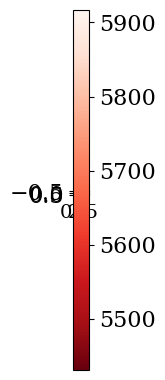

In [199]:
import pylab as pl

# a = np.array([[0,1]])
fig, ax = plt.subplots(figsize=(0.2,6))
fig.gca().set_visible(True)
cax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
a = subset_df[objective].values.reshape((1,n))
img = ax.imshow(a, cmap="Reds_r")
# cax.tick_params(labelsize=10)
# cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])# horizontal colorbar
cbar.set_ticks([0.65, 0.89, 0.25, 0.01])
cbar = fig.colorbar(img, orientation="vertical",cax=cax)
cbar.update_ticks()

In [121]:
ddf = pd.DataFrame(dict(zip(techs,results.X.T)))

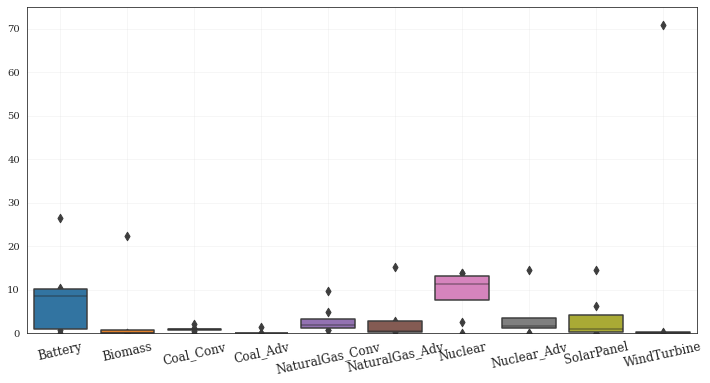

In [26]:
fig, axes = plt.subplots(1,1,figsize=(12,6), facecolor='w', sharex=True, sharey=True)
peak_demand = results.problem.max_demand
sb.boxenplot(ax=axes, data=(results.X)*peak_demand)

axes.set_xticklabels(techs, rotation=12.5, size=12)
axes.set_xticks(range(len(techs)))
# axes[2].set_ylabel("Capacity (GW)", size=14)
axes.set_xlabel("", size=14)
axes.set_ylim(0,75)

axes.grid(alpha=0.2, which='major')
axes.grid(alpha=0.05, which='minor')

In [45]:
mdf

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,designs
0,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
1,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
2,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
3,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
4,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
...,...,...,...,...,...
173,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."
174,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."
175,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."
176,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."


In [63]:
designs = np.array([list(design) for design in mdf.designs.values])

In [64]:
designs_df = pd.DataFrame(dict(zip(techs,designs.T)))

In [70]:
designs_df

,Battery,Biomass,Coal_Conv,Coal_Adv,NaturalGas_Conv,NaturalGas_Adv,Nuclear,Nuclear_Adv,SolarPanel,WindTurbine
0,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
1,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
2,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
3,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
4,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
...,...,...,...,...,...,...,...,...,...,...
173,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130
174,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130
175,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130
176,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130


In [65]:
frames = [mdf.iloc[:,:4], designs_df]
mdf_expanded = pd.concat(frames, axis=1)

In [67]:
mdf_expanded

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,Battery,Biomass,Coal_Conv,Coal_Adv,NaturalGas_Conv,NaturalGas_Adv,Nuclear,Nuclear_Adv,SolarPanel,WindTurbine
0,6349.835709,21.668460,21507.513418,0.951782,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
1,6349.835709,21.668460,21507.513418,0.951782,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
2,6349.835709,21.668460,21507.513418,0.951782,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
3,6349.835709,21.668460,21507.513418,0.951782,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
4,6349.835709,21.668460,21507.513418,0.951782,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,6057.686809,13.057704,2502.319232,0.962571,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130
174,6057.686809,13.057704,2502.319232,0.962571,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130
175,6057.686809,13.057704,2502.319232,0.962571,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130
176,6057.686809,13.057704,2502.319232,0.962571,0.342434,0.022398,0.028729,0.003573,0.025520,0.021724,0.473686,0.114481,0.017922,0.000130


In [68]:
mdf_expanded = mdf_expanded.drop_duplicates().reset_index(drop=True)

In [69]:
mdf_expanded

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,Battery,Biomass,Coal_Conv,Coal_Adv,NaturalGas_Conv,NaturalGas_Adv,Nuclear,Nuclear_Adv,SolarPanel,WindTurbine
0,6349.835709,21.668460,21507.513418,0.951782,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
1,6344.245186,21.654545,21507.462122,0.952233,0.741562,0.006682,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
2,5949.458670,20.005281,15416.608169,0.979554,0.013693,0.015743,0.010694,0.009032,0.566365,0.033174,0.574264,0.003143,0.010036,0.038874
3,8309.882517,2.402467,6257.102949,0.992094,0.764091,0.000270,0.001846,0.038100,0.384120,0.073007,0.488238,0.266893,0.002902,0.015574
4,8606.337239,2.550485,6271.208382,0.988252,0.296661,0.000065,0.520851,0.022773,0.027388,0.038240,0.808569,0.142115,0.045845,0.000303
5,8341.828465,2.404744,6588.509200,0.988601,0.279696,0.005114,0.492697,0.001203,0.075734,0.158390,0.678595,0.160704,0.035962,0.004743
6,5497.018807,27.930092,29295.654111,0.935974,0.354288,0.000377,0.069821,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
7,5520.749740,28.453851,29296.059147,0.935911,0.354288,0.000593,0.072283,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
8,6178.461961,13.610238,5504.969343,0.992079,0.298075,0.006473,0.023906,0.002222,0.055718,0.035741,0.490168,0.137682,0.011513,0.010774
9,6273.116422,13.011507,5238.990823,0.974914,0.255490,0.035448,0.010025,0.003675,0.062012,0.051939,0.493553,0.100592,0.038523,0.000391


In [120]:
mdf_expanded.iloc[:,4:]

,Battery,Biomass,Coal_Conv,Coal_Adv,NaturalGas_Conv,NaturalGas_Adv,Nuclear,Nuclear_Adv,SolarPanel,WindTurbine
0,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
1,0.741562,0.006682,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
2,0.013693,0.015743,0.010694,0.009032,0.566365,0.033174,0.574264,0.003143,0.010036,0.038874
3,0.764091,0.000270,0.001846,0.038100,0.384120,0.073007,0.488238,0.266893,0.002902,0.015574
4,0.296661,0.000065,0.520851,0.022773,0.027388,0.038240,0.808569,0.142115,0.045845,0.000303
5,0.279696,0.005114,0.492697,0.001203,0.075734,0.158390,0.678595,0.160704,0.035962,0.004743
6,0.354288,0.000377,0.069821,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
7,0.354288,0.000593,0.072283,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
8,0.298075,0.006473,0.023906,0.002222,0.055718,0.035741,0.490168,0.137682,0.011513,0.010774
9,0.255490,0.035448,0.010025,0.003675,0.062012,0.051939,0.493553,0.100592,0.038523,0.000391


In [124]:
pd.concat([mdf_expanded.iloc[:,4:],ddf], axis=0).reset_index()

,index,Battery,Biomass,Coal_Conv,Coal_Adv,NaturalGas_Conv,NaturalGas_Adv,Nuclear,Nuclear_Adv,SolarPanel,WindTurbine
0,0,0.741562,6.974143e-03,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
1,1,0.741562,6.681875e-03,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
2,2,0.013693,1.574325e-02,0.010694,0.009032,0.566365,0.033174,0.574264,0.003143,0.010036,0.038874
3,3,0.764091,2.701567e-04,0.001846,0.038100,0.384120,0.073007,0.488238,0.266893,0.002902,0.015574
4,4,0.296661,6.517489e-05,0.520851,0.022773,0.027388,0.038240,0.808569,0.142115,0.045845,0.000303
5,5,0.279696,5.114035e-03,0.492697,0.001203,0.075734,0.158390,0.678595,0.160704,0.035962,0.004743
6,6,0.354288,3.773002e-04,0.069821,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
7,7,0.354288,5.925067e-04,0.072283,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
8,8,0.298075,6.472591e-03,0.023906,0.002222,0.055718,0.035741,0.490168,0.137682,0.011513,0.010774
9,9,0.255490,3.544828e-02,0.010025,0.003675,0.062012,0.051939,0.493553,0.100592,0.038523,0.000391


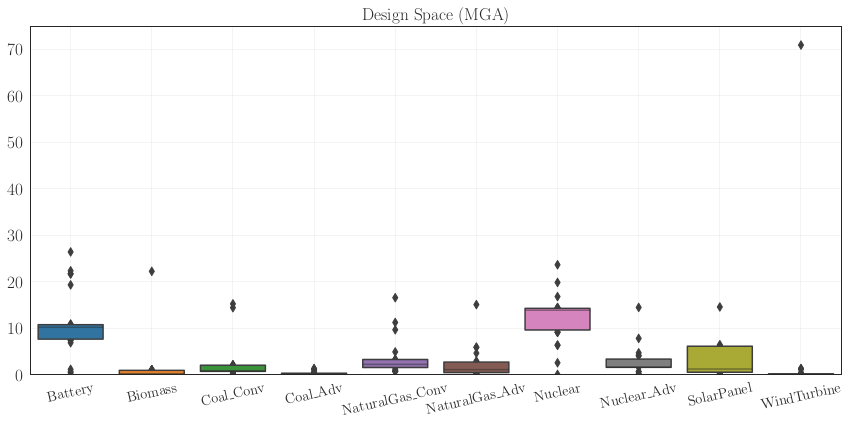

In [129]:
fig, axes = plt.subplots(1,1,figsize=(12,6), facecolor='w', sharex=True, sharey=True)
peak_demand = results.problem.max_demand
sb.boxenplot(ax=axes, 
             data=(pd.concat([mdf_expanded.iloc[:,4:],
                              ddf], 
                             axis=0).reset_index(drop=True))*peak_demand)

axes.set_xticklabels(techs, rotation=12.5, size=14)
axes.set_xticks(range(len(techs)))
# axes[2].set_ylabel("Capacity (GW)", size=14)
axes.set_xlabel("", size=14)
axes.set_ylim(0,75)

axes.grid(alpha=0.2, which='major')
axes.grid(alpha=0.05, which='minor')
axes.set_title("Design Space (MGA)", fontsize=16)
plt.tight_layout()
plt.savefig("../docs/figures/results/4-obj-mga-design-space.pgf")

# Homegrown PCP